# Description

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this task, we have to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')
import re
import spacy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

from transformers import logging
logging.set_verbosity(logging.ERROR)

nlp = spacy.load('en_core_web_sm')


In [4]:
data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [215]:
data.shape

(7613, 5)

In [216]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [217]:
def plotBarGraph(res, column_name, start=0, top=10, show=False, rotate=False, xticks=None):
    plt.figure(figsize=(15, 6))
    plt.bar(res[column_name][start:top], res['count'][start:top])
    plt.xlabel(column_name, fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.title(f'{column_name} Frequency', fontsize=16)

    for i, value in enumerate(res['count'][start:top]):
        plt.text(res[column_name][start + i], value + 0.5, str(value), ha='center', fontsize=16)
        
    plt.xticks(xticks,fontsize=13)
    plt.yticks(fontsize=13)
    
    if rotate:
        plt.xticks(rotation=90)

    if show:
        plt.savefig(f'{column_name}_freq.png')
        plt.show()
    else:
        plt.show()

# Data Distribution

In [218]:
set(data['target'])

{0, 1}

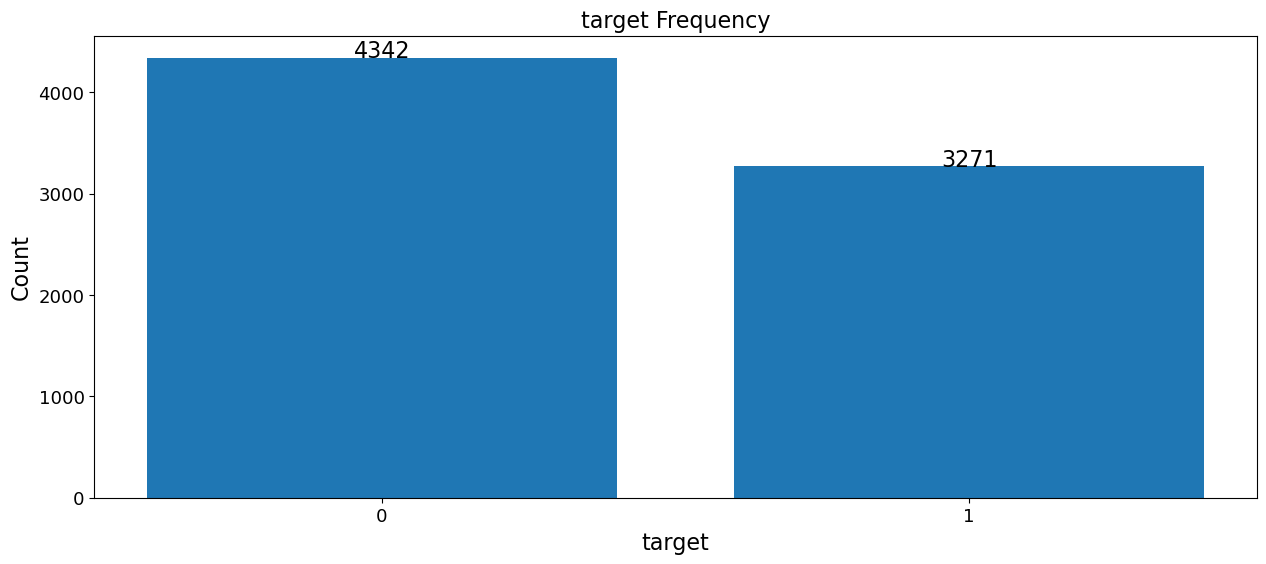

In [9]:
plotBarGraph(pd.DataFrame(data['target'].value_counts()).reset_index().rename(columns={'index':'target','target':'count'}), column_name='target', xticks=[0,1])

# Distribution of tweet length

<Axes: xlabel='tweet_length', ylabel='Density'>

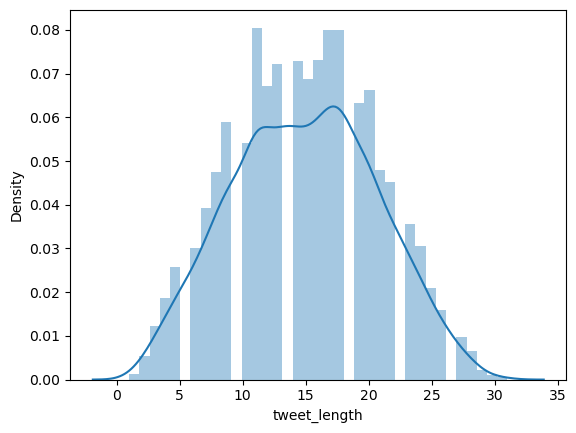

In [219]:
import seaborn as sns
data['tweet_length'] = data['text'].apply(lambda text: len(text.split()))
sns.distplot(data['tweet_length'])

# Distribution of tweets length by target

Text(0.5, 1.0, 'target = 1 (disaster)')

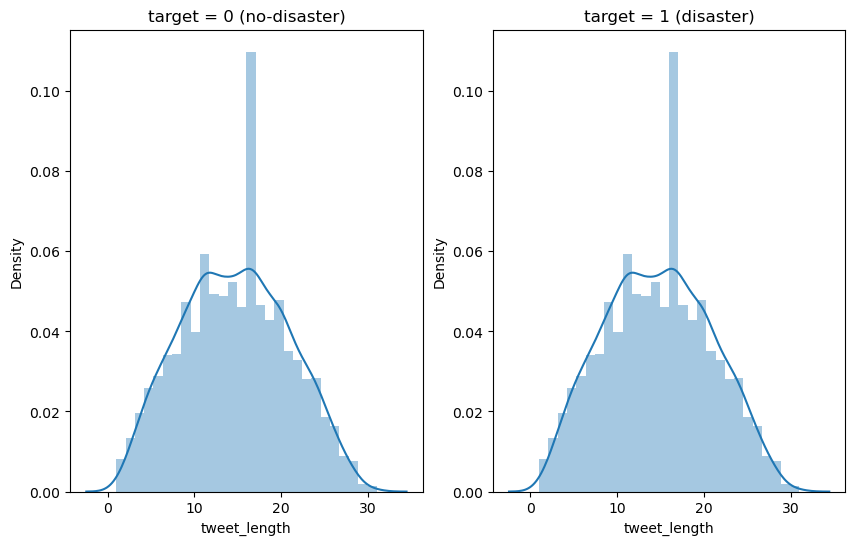

In [220]:
import seaborn as sns
_,ax = plt.subplots(1,2, figsize=(10,6))
sns.distplot(data['tweet_length'][data['target'] == 0], ax=ax[0])
ax[0].set_title("target = 0 (no-disaster)")
sns.distplot(data['tweet_length'][data['target'] == 0], ax=ax[1])
ax[1].set_title("target = 1 (disaster)")

In [221]:
data[~data['keyword'].isnull()]

,id,keyword,location,text,target,tweet_length
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,5
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,10
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,9
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,7
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,13
...,...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0,7
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,20
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,12
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0,13


In [222]:
import re
def clean_tweet(tweet, for_eda=False, for_vector=False):
    # Remove URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE) 
    
    tweet = re.sub(r'#', ' ', tweet) 
    
    #tweet = re.sub(r'#\w+', ' ', tweet) 
    
    # Remove mentions
    tweet = re.sub(r'\@\w+', '', tweet)
    # Remove special characters and punctuations
    tweet = re.sub(r'[^\w\s]', '', tweet)
    # Remove emoticons
    tweet = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', '', tweet)
    # Convert to lowercase
    tweet = tweet.lower()
    # Remove extra whitespace
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    if for_eda:
        tokens = tweet.split()
        cleaned_tokens = [token.lemma_ for token in nlp(tweet) if not token.is_stop and token.is_alpha and len(token)>1]  
        tweet = " ".join(cleaned_tokens)
        
    return tweet

In [223]:
data['text'][31]

'@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C'

In [224]:
data['cleaned_text_for_eda'] = data['text'].apply(clean_tweet, args=[True])
data['cleaned_text_for_eda'][31]

'wholesale market ablaze'

# Most frquent words in disaster related tweets

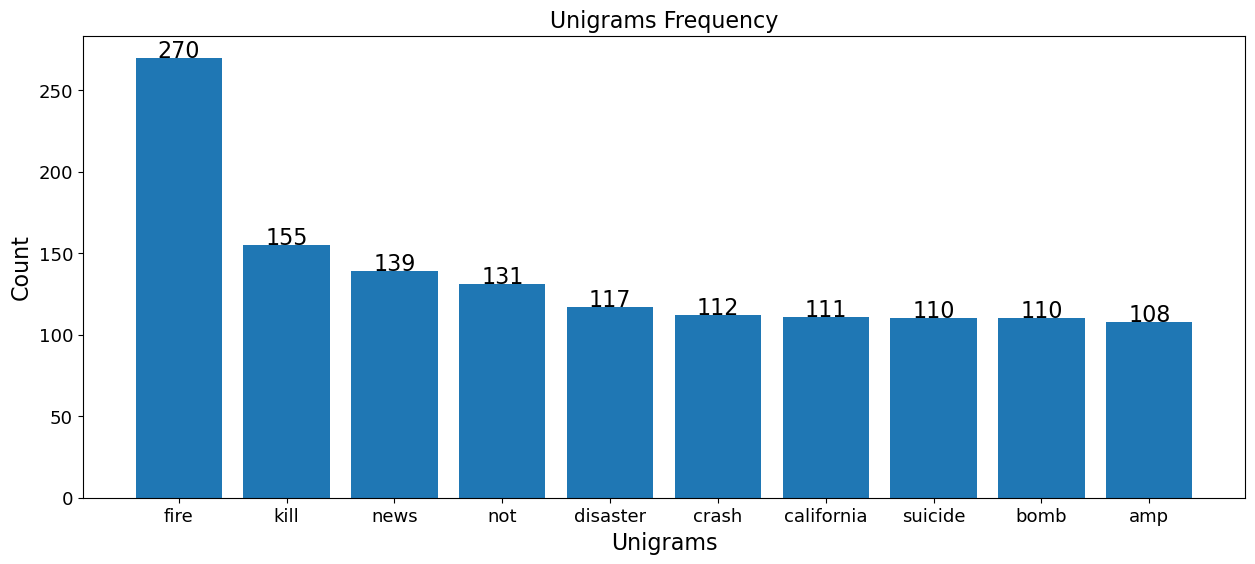

In [225]:
tokenized_texts_1 = [text.split() for text in data['cleaned_text_for_eda'][data['target'] == 1].values]

# Count word frequency
unigram_word_frequency = Counter()
for tokens in tokenized_texts_1:
    unigram_word_frequency.update(tokens)
    
res = pd.DataFrame(unigram_word_frequency.most_common(10), columns=['Unigrams', 'count'])
    
plotBarGraph(res,column_name="Unigrams")

# Most frquent words in non- disaster related tweets

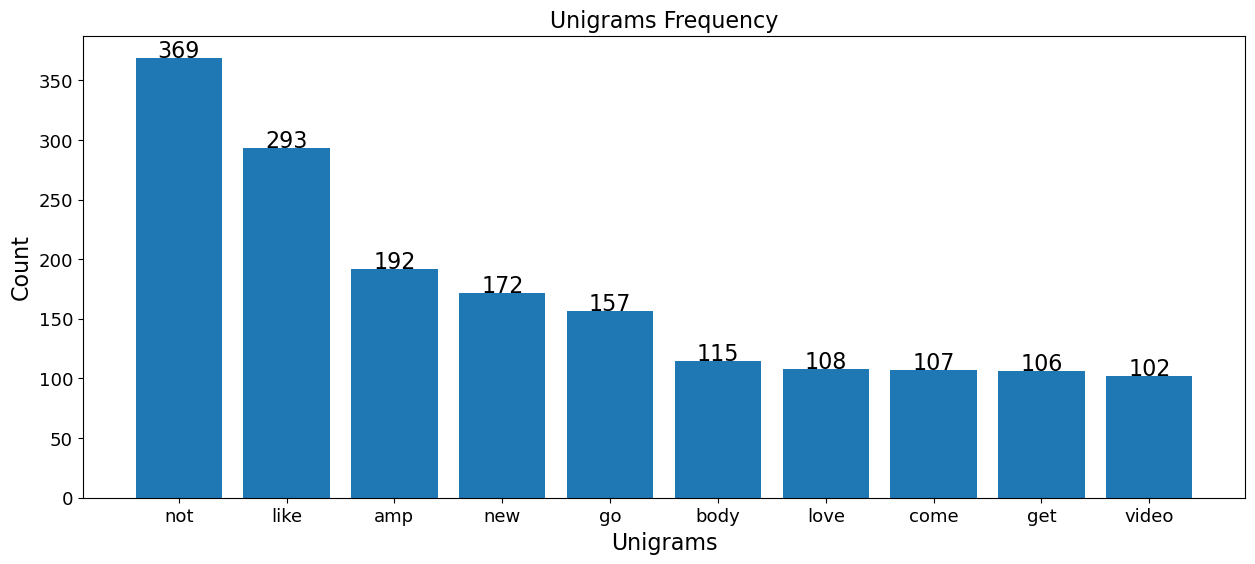

In [226]:
tokenized_texts_0 = [text.split() for text in data['cleaned_text_for_eda'][data['target'] == 0].values]

# Count word frequency
unigram_word_frequency = Counter()
for tokens in tokenized_texts_0:
    unigram_word_frequency.update(tokens)
    
res = pd.DataFrame(unigram_word_frequency.most_common(10), columns=['Unigrams', 'count'])
    
plotBarGraph(res,column_name="Unigrams")

Text(0.5, 1.0, 'Words in Disaster Tweets')

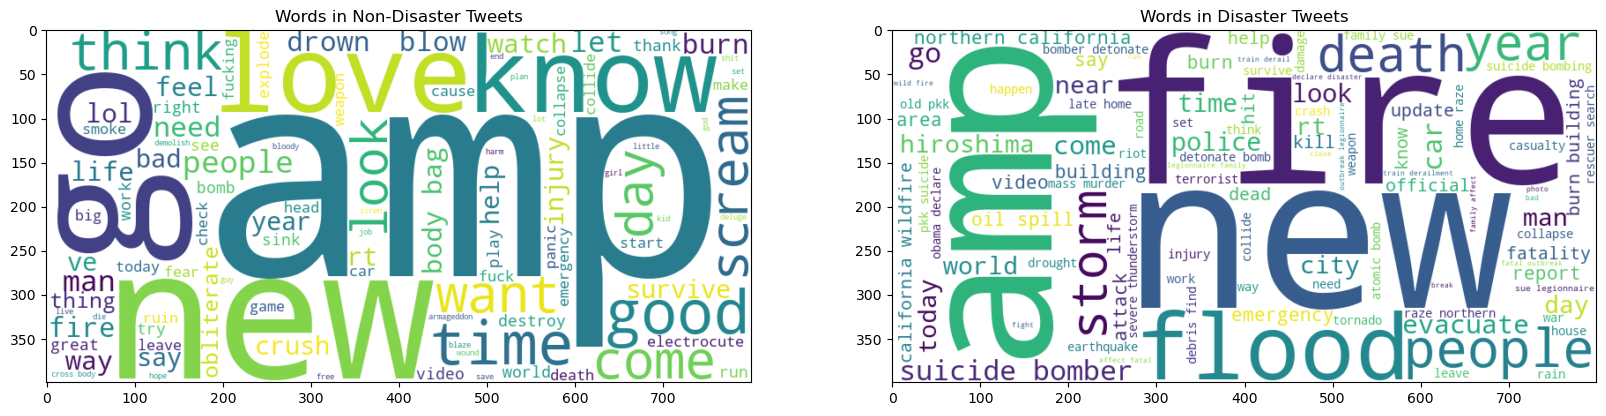

In [227]:
tokenized_texts_0_sentence = " ".join([word for word_list in tokenized_texts_0 for word in word_list])
tokenized_texts_1_sentence = " ".join([word for word_list in tokenized_texts_1 for word in word_list])

_,ax = plt.subplots(1,2,figsize=(20,10) )
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', contour_width=3, 
                      contour_color='steelblue', max_words=100).generate(tokenized_texts_0_sentence)
ax[0].imshow(wordcloud, interpolation='bilinear')
ax[0].set_title("Words in Non-Disaster Tweets")

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', contour_width=3, 
                      contour_color='steelblue', max_words=100).generate(tokenized_texts_1_sentence)
ax[1].imshow(wordcloud, interpolation='bilinear')
ax[1].set_title("Words in Disaster Tweets")

# Most frquent bigrams in disaster related tweets

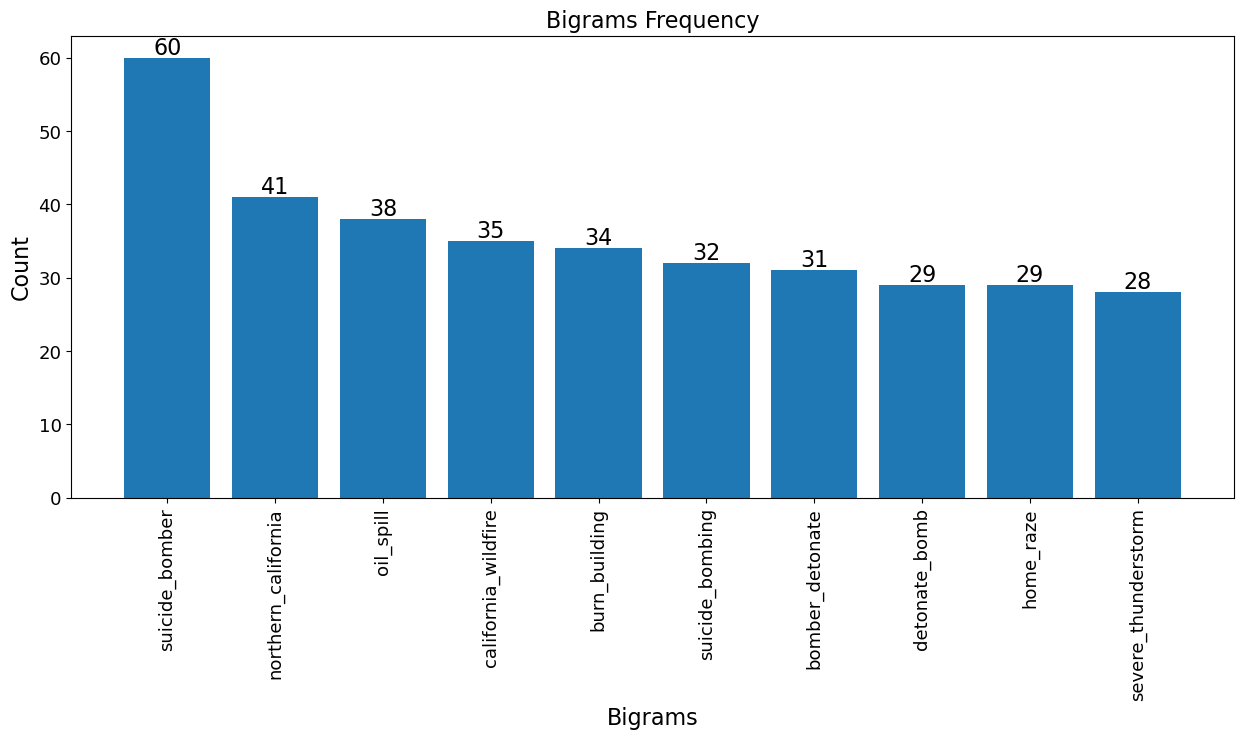

In [228]:
import nltk
from nltk import bigrams, ngrams
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

# Generate bigrams from the tokenized data
all_bigrams_tokenized_texts_1 = [list(bigrams(sentence)) for sentence in tokenized_texts_1]

# Flatten the list of bigrams
all_bigrams_tokenized_texts_1_flat = [bigram for sentence_bigrams in all_bigrams_tokenized_texts_1 for bigram in sentence_bigrams]

# Calculate the frequency distribution of the bigrams
freq_dist = FreqDist(all_bigrams_tokenized_texts_1_flat)

# Get the top 10 most frequent bigrams
top_10_bigrams = freq_dist.most_common(10)

# Extract the bigrams and their frequencies
bigrams, bigrams_frequencies = zip(*top_10_bigrams)

bigrams = ["_".join(bigram) for bigram in bigrams]

res = pd.DataFrame(zip(bigrams,bigrams_frequencies), columns=['Bigrams', 'count'])
    
plotBarGraph(res,column_name="Bigrams",start=0, rotate=True)

# Most frquent bigrams in non-disaster related tweets

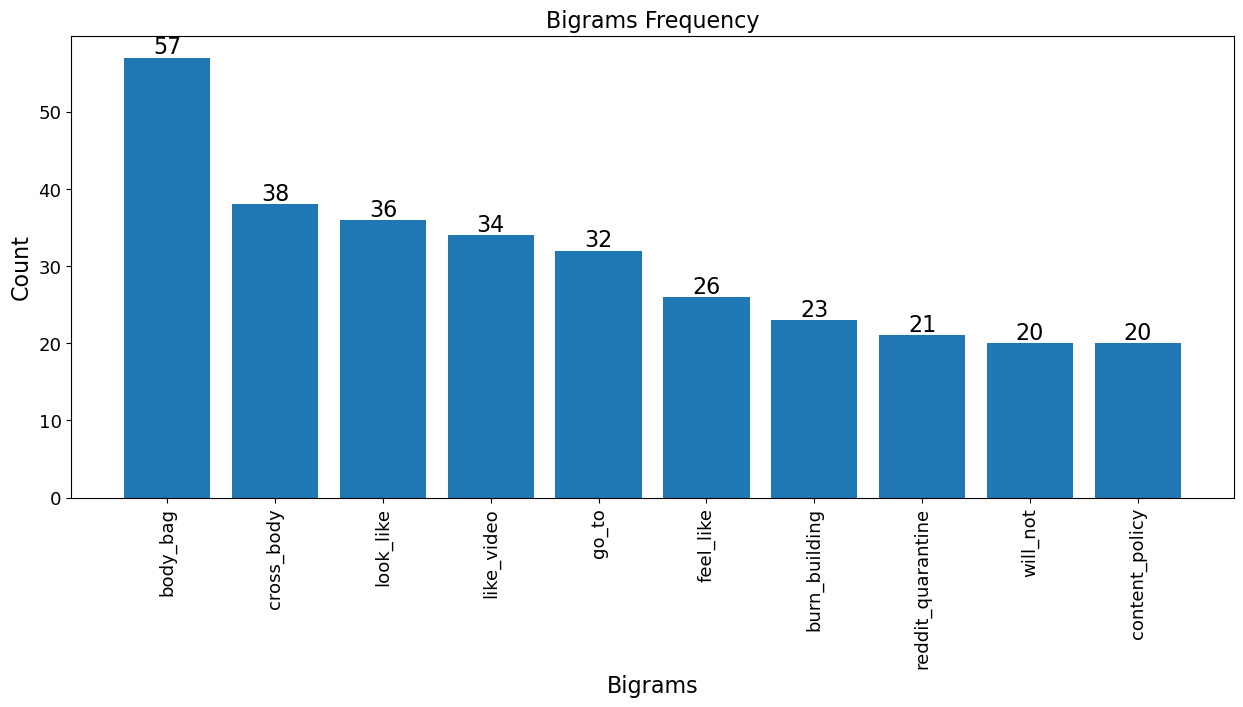

In [229]:
import nltk
from nltk import bigrams, ngrams
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

lens = pd.Series(tokenized_texts_0).apply(lambda x: len(x))
# Generate bigrams from the tokenized data
all_bigrams_tokenized_texts_0 = [list(bigrams(sentence)) for sentence in pd.Series(tokenized_texts_0)[lens!=0].values]

# Flatten the list of bigrams
all_bigrams_tokenized_texts_0_flat = [bigram for sentence_bigrams in all_bigrams_tokenized_texts_0 for bigram in sentence_bigrams]

# Calculate the frequency distribution of the bigrams
freq_dist = FreqDist(all_bigrams_tokenized_texts_0_flat)

# Get the top 10 most frequent bigrams
top_10_bigrams = freq_dist.most_common(10)

# Extract the bigrams and their frequencies
bigrams, bigrams_frequencies = zip(*top_10_bigrams)

bigrams = ["_".join(bigram) for bigram in bigrams]

res = pd.DataFrame(zip(bigrams,bigrams_frequencies), columns=['Bigrams', 'count'])
    
plotBarGraph(res,column_name="Bigrams",start=0, rotate=True)

# Lets analyze topics related to disaster tweets

In [300]:
#!pip install bertopic

In [ ]:
from bertopic import BERTopic

preprocessed_text = data['cleaned_text_for_eda'][data['target']==1].values

# Initialize BERTopic model with ClinicalBERT tokenizer and model
topic_model = BERTopic(nr_topics=16, min_topic_size=3)

# Fit the model to the documents
topics, _ = topic_model.fit_transform(preprocessed_text)
top_words = topic_model.get_topics()

# Below are main topics being discussed in Disaster related tweets. Note that topic -1 is outlier topic

In [232]:
topic_representation = {}
top= 5
for topic_id, words in top_words.items():
    topic_representation[topic_id] = "|".join([word[0] for word in words[:top]])
    
topic_representation

{-1: 'fire|amp|not|storm|crash',
 0: 'fire|wildfire|california|northern|disaster',
 1: 'suicide|bomb|bomber|attack|hiroshima',
 2: 'train|police|accident|derail|bus',
 3: 'mass|murder|coach|not|tragedy',
 4: 'debris|collapse|malaysia|crash|reunion',
 5: 'legionnaire|family|outbreak|sue|affect',
 6: 'migrant|hundred|sinkhole|search|rescuer',
 7: 'earthquake|km|seismic|eruption|volcano',
 8: 'airport|sandstorm|minute|swallow|watch',
 9: 'oil|spill|project|costlier|refugio',
 10: 'detonation|ignition|mop|knock|apollo',
 11: 'aba|deliver|pandemonium|woman|baby',
 12: 'hollywood|miner|trap|movie|chile',
 13: 'cancer|kowe|beclearoncancer|blackpool|equate',
 14: 'inner|silver|exit|md|loop'}

In [233]:
topic_model.set_topic_labels(topic_representation)

# Below plot shows 16 different topics with some overlapping

In [236]:
# !pip install -U kaleido
# !pip install psutil requests
# !pip install plotly>=5.0.0
from plotly.io import to_image
from IPython.display import Image

In [237]:
fig = topic_model.visualize_topics(custom_labels=True)
image_bytes = to_image(fig, format='png')

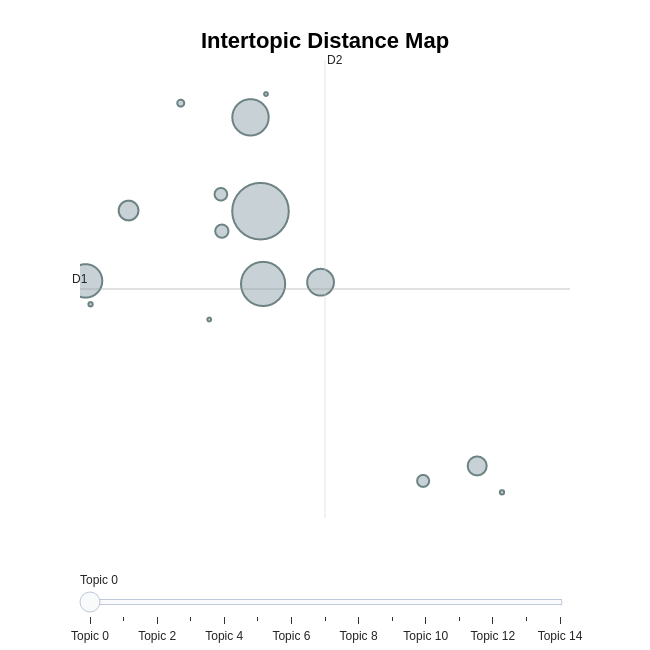

In [238]:
Image(image_bytes)

# Below is most frequent top 10 words from each topic

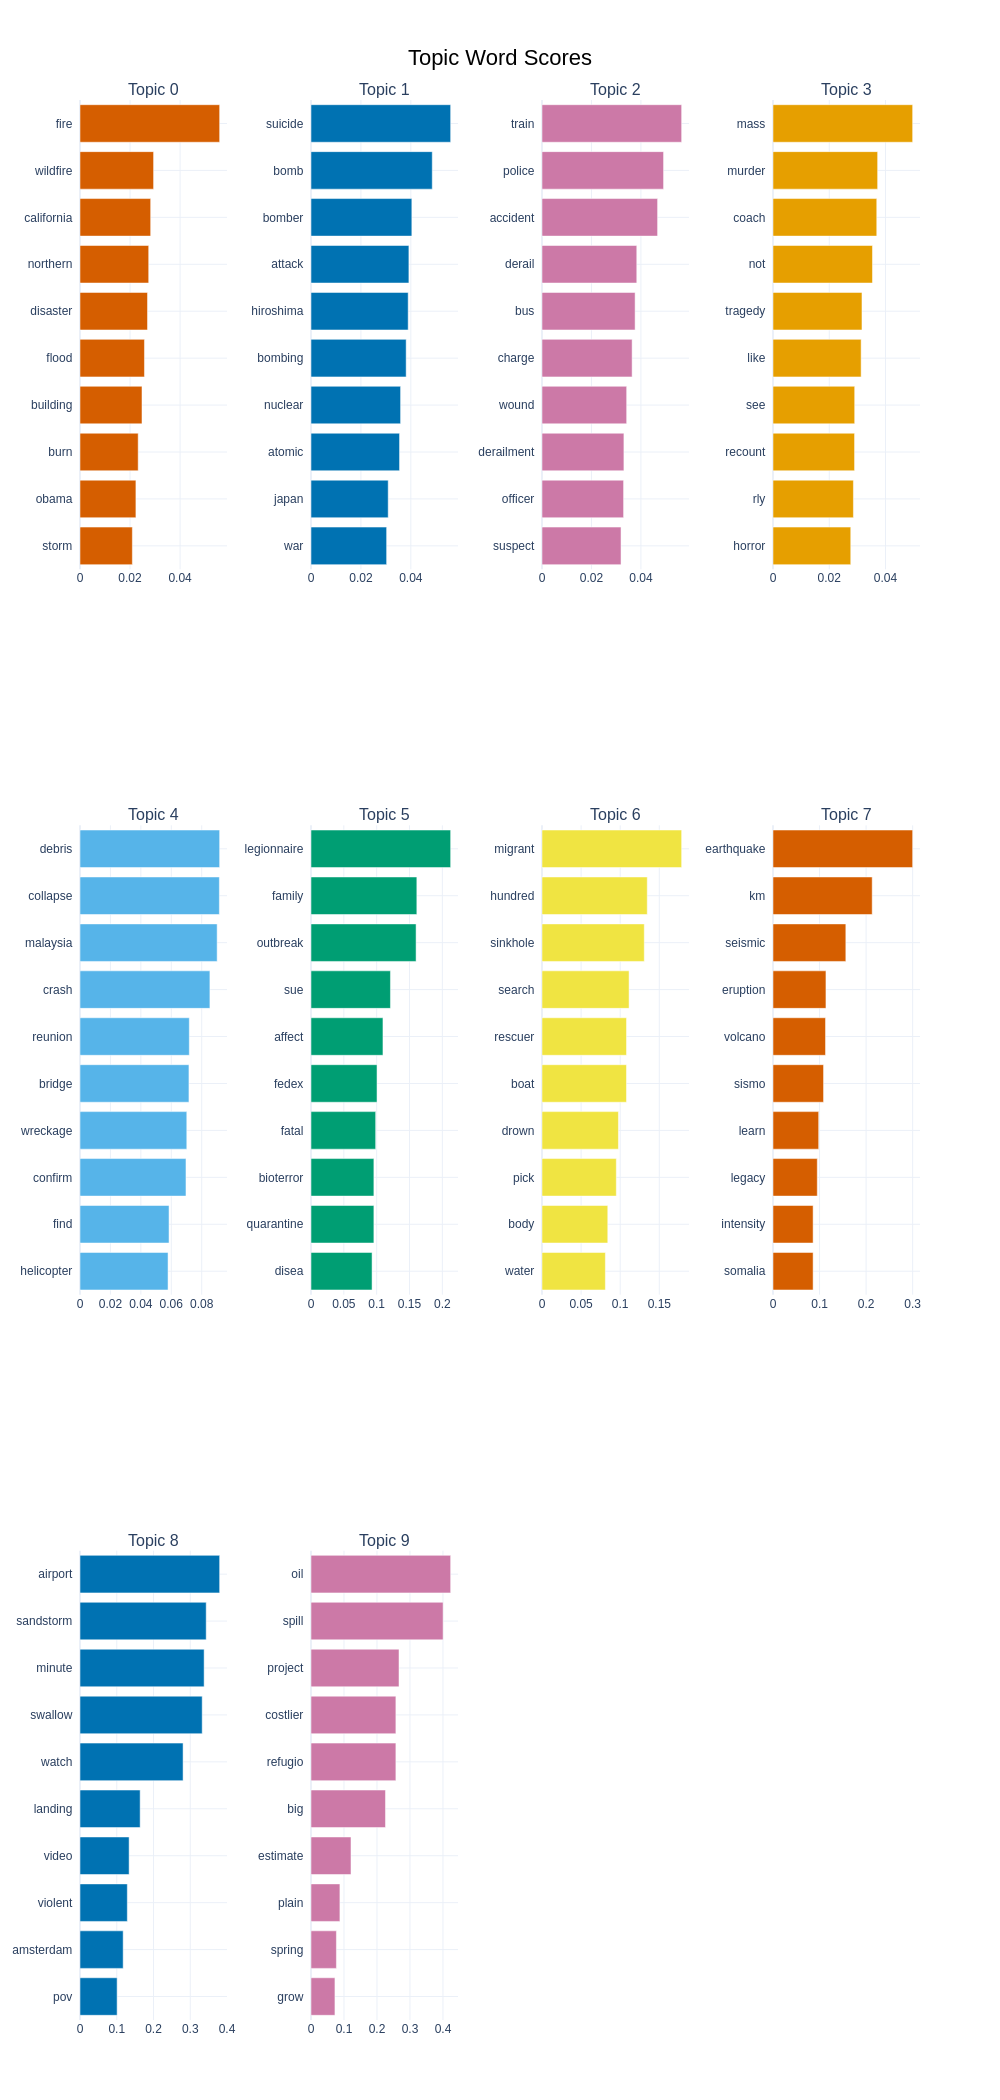

In [239]:
fig = topic_model.visualize_barchart(top_n_topics=10, n_words=10, height=700)
image_bytes = to_image(fig, format='png')
Image(image_bytes)

# Below plot the similarity among each topic

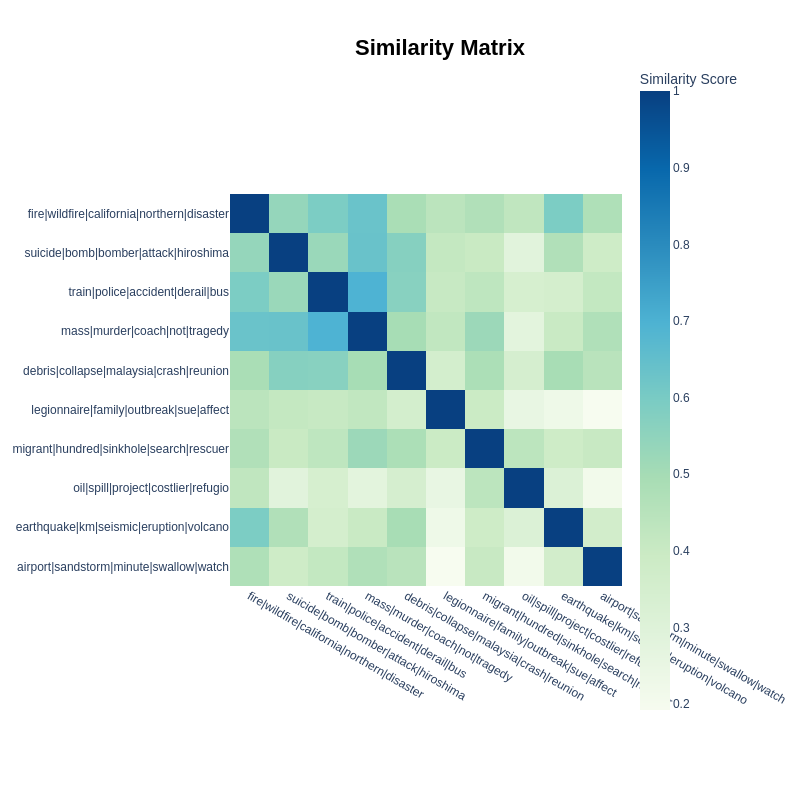

In [240]:
fig = topic_model.visualize_heatmap(n_clusters=4, top_n_topics=10, custom_labels=True, width = 800, height = 800)
image_bytes = to_image(fig, format='png')
Image(image_bytes)

# Analyzing topics being discussed in Non- Disaster related tweets

In [241]:
from bertopic import BERTopic

preprocessed_text = data['cleaned_text_for_eda'][data['target']==0].values

# Initialize BERTopic model with ClinicalBERT tokenizer and model
topic_model_0 = BERTopic(nr_topics=16, min_topic_size=3)

# Fit the model to the documents
topics_0, _ = topic_model_0.fit_transform(preprocessed_text)
top_words_0 = topic_model_0.get_topics()

# Below are main topics being discussed in NON-Disaster realted tweets.

In [242]:
topic_representation = {}
top= 5
for topic_id, words in top_words_0.items():
    topic_representation[topic_id] = "|".join([word[0] for word in words[:top]])
    
topic_representation

{-1: 'not|amp|like|new|get',
 0: 'not|like|amp|love|go',
 1: 'electrocute|emergency|job|service|plan',
 2: 'bag|body|cross|shoulder|stretcher',
 3: 'reddit|quarantine|content|offensive|policy',
 4: 'detonate|ignition|detonation|knock|mop',
 5: 'rescue|horse|national|sign|animalrescue',
 6: 'nuclear|reactor|seismic|finnish|ahead',
 7: 'eyewitness|ebay|travel|navy|guide',
 8: 'fedex|bioterror|transport|long|pathogen',
 9: 'army|pick|fan|beyhive|directioner',
 10: 'aba|deliver|wedding|pandemonium|syrian',
 11: 'texas|windstorm|insurer|comment|seek',
 12: 'miner|hollywood|chile|trap|movie',
 13: 'bus|chicagoarea|scheme|admit|arson',
 14: 'mayan|tablet|lowly|honor|hieroglyphic'}

In [243]:
topic_model_0.set_topic_labels(topic_representation)

# Below plot shows 16 different topics alomost clearly sprarated 

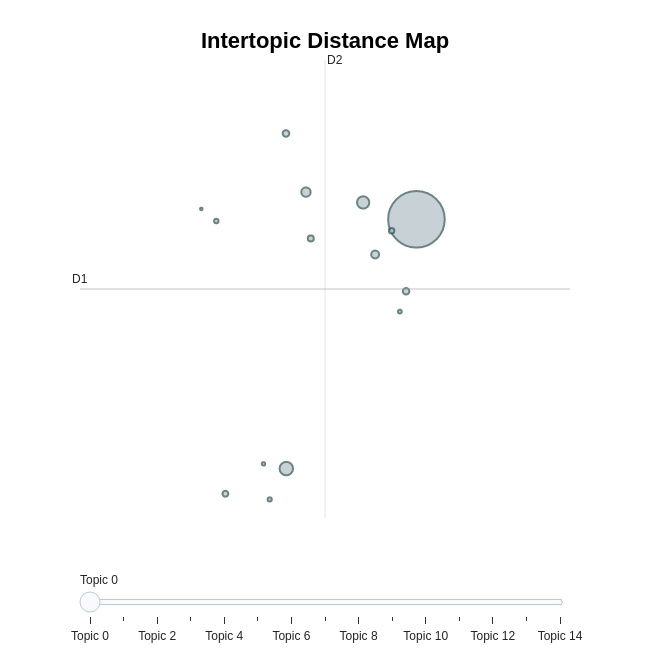

In [244]:
fig = topic_model_0.visualize_topics(custom_labels=True)
image_bytes = to_image(fig, format='png')
Image(image_bytes)

# Below is most frequent top 10 words from each topic

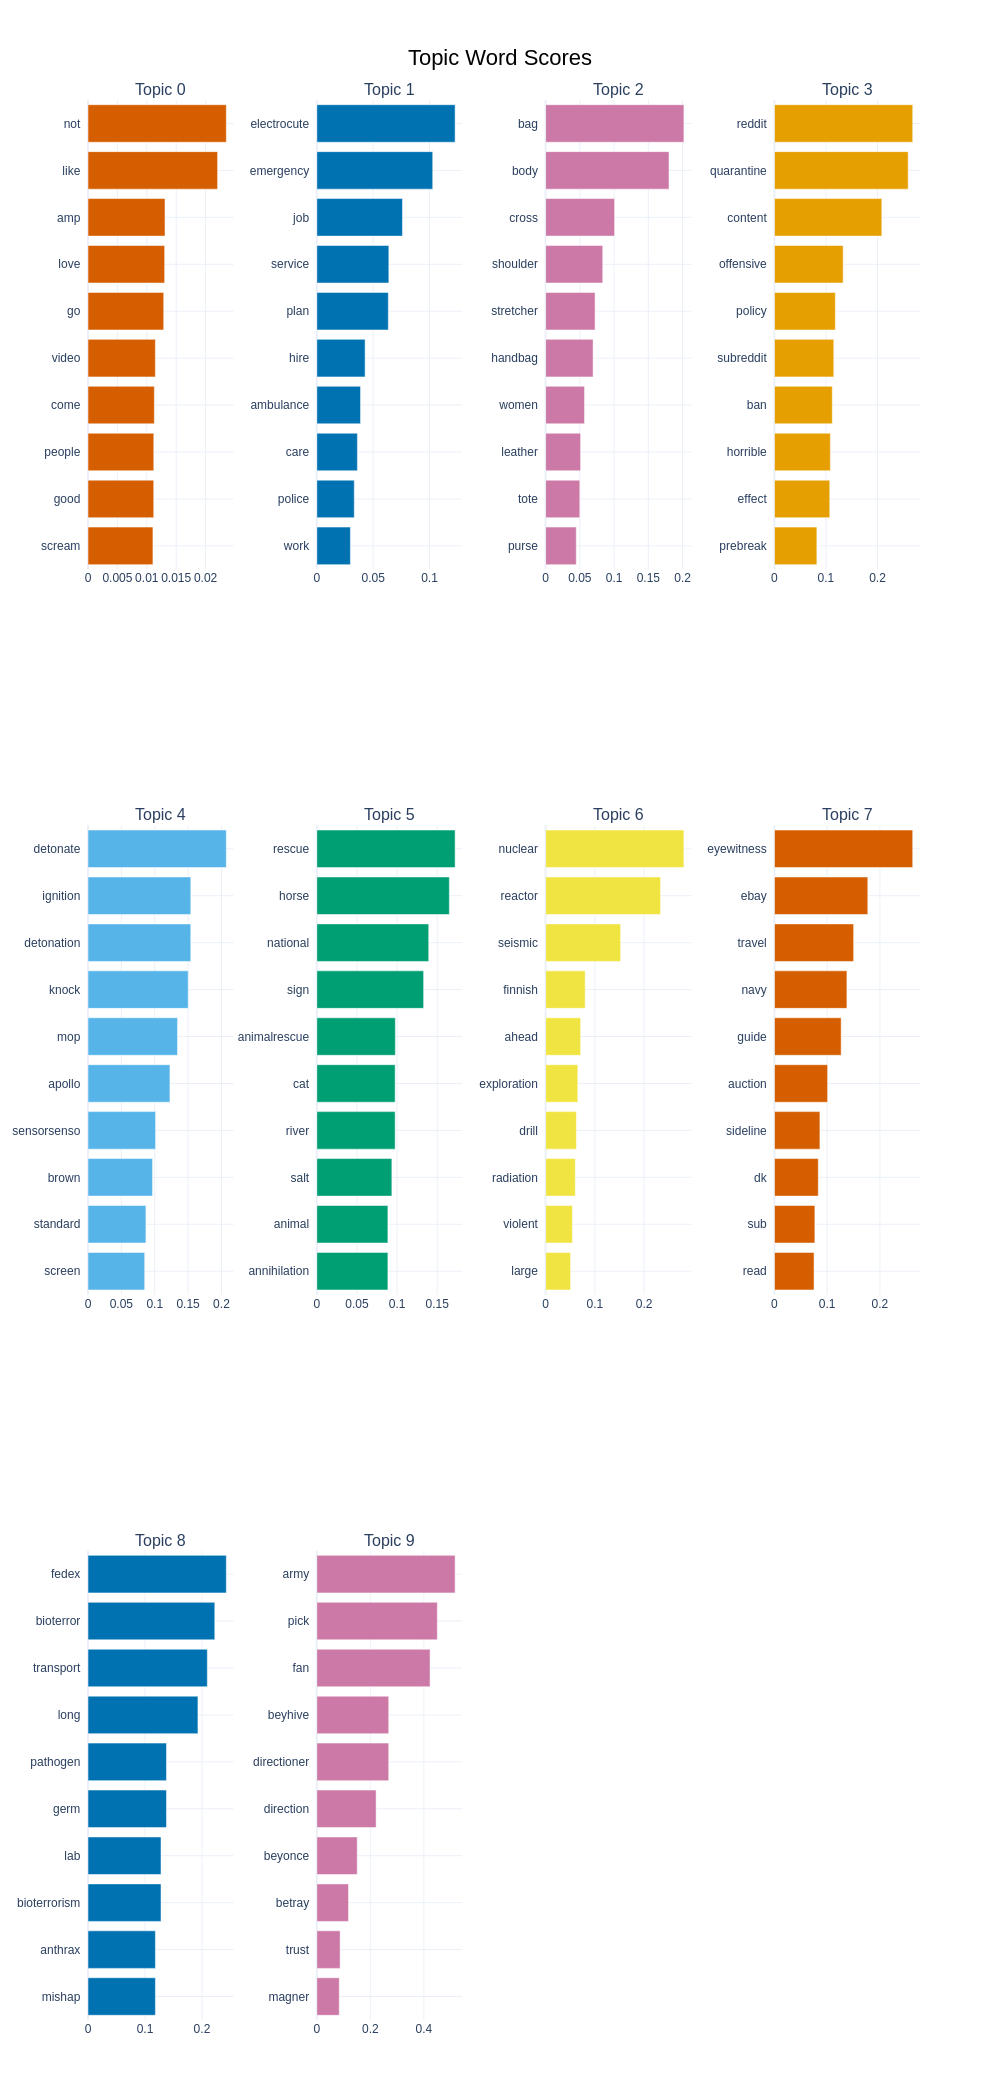

In [245]:
fig = topic_model_0.visualize_barchart(top_n_topics=10, n_words=10, height=700)
image_bytes = to_image(fig, format='png')
Image(image_bytes)

# Below plot the similarity among each topic

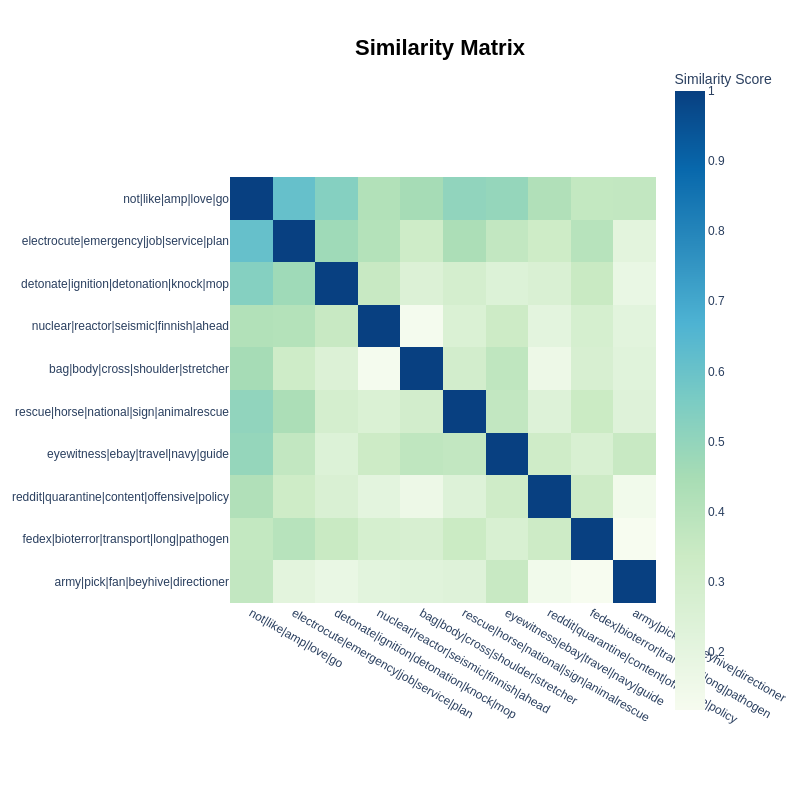

In [246]:
fig = topic_model_0.visualize_heatmap(n_clusters=4, top_n_topics=10, custom_labels=True, width = 800, height = 800)
image_bytes = to_image(fig, format='png')
Image(image_bytes)

# Model building

In [247]:
data['text'] = data['text'].apply(clean_tweet)

# Using Roberta model trained on tweets and finetuned on semement analysis task to futher finetune on this task

In [248]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.model_selection import train_test_split
from transformers import TFAutoModel, AutoTokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

batch_size = 10


model_name = "finiteautomata/bertweet-base-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = TFAutoModel.from_pretrained(model_name)
bert_model.trainable = True

#Define the classification model
input_ids = Input(shape=(None,), name='input_ids', dtype=tf.int32)
attention_mask = Input(shape=(None,), name='attention_mask', dtype=tf.int32)
pooled_output = bert_model(input_ids, attention_mask).pooler_output
dense_1 = Dense(512, activation='tanh')(pooled_output)
dropout_1 = Dropout(0.5)(dense_1)

dense_2 = Dense(256, activation='tanh')(dropout_1)
dropout_2 = Dropout(0.5)(dense_2)

dense_3 = Dense(128, activation='tanh')(dropout_2)
dropout_3 = Dropout(0.5)(dense_3)
outputs = Dense(1, activation='sigmoid')(dropout_3)

model = Model(inputs=[input_ids, attention_mask], outputs=outputs)


optimizer = Adam(learning_rate=.000002)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.1, random_state=42)

train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)


train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    y_train
)).shuffle(len(train_encodings['input_ids'])).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']},
    y_test
)).batch(batch_size)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  134899968  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, None                                           

In [249]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,           
    restore_best_weights=True  
)

In [250]:
num_epochs = 15
history  = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)

Epoch 1/15
686/686 [==============================] - 191s 192ms/step - loss: 0.6140 - accuracy: 0.6545 - val_loss: 0.4907 - val_accuracy: 0.7782
Epoch 2/15
686/686 [==============================] - 98s 143ms/step - loss: 0.4519 - accuracy: 0.8173 - val_loss: 0.4488 - val_accuracy: 0.8189
Epoch 3/15
686/686 [==============================] - 97s 141ms/step - loss: 0.4080 - accuracy: 0.8393 - val_loss: 0.4285 - val_accuracy: 0.8320
Epoch 4/15
686/686 [==============================] - 97s 141ms/step - loss: 0.3760 - accuracy: 0.8535 - val_loss: 0.4795 - val_accuracy: 0.8136
Epoch 5/15
686/686 [==============================] - 96s 140ms/step - loss: 0.3564 - accuracy: 0.8666 - val_loss: 0.4837 - val_accuracy: 0.8215
Epoch 6/15
686/686 [==============================] - 97s 142ms/step - loss: 0.3375 - accuracy: 0.8749 - val_loss: 0.4988 - val_accuracy: 0.8228


# Analysize and plot between train and val loss

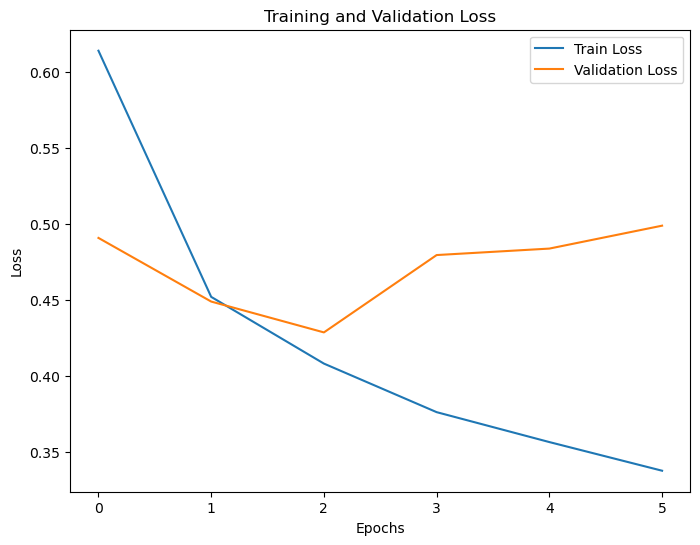

In [251]:
# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# below is a helper funtion to get prediction for each record

In [252]:
def get_prediction(sentence):

    tokens = tokenizer(sentence, padding=True, truncation=True, return_tensors="tf")

    input_ids = tokens["input_ids"]
    attention_mask = tokens["attention_mask"]

    outputs = model.predict([input_ids,attention_mask], verbose=0)
    
    return outputs[0][0]

# I will use AUC-ROC plot to come-up with best probability threshold for this task

# Verify probability threshold for best accuracy

In [253]:
roc_test = pd.Series(X_test)

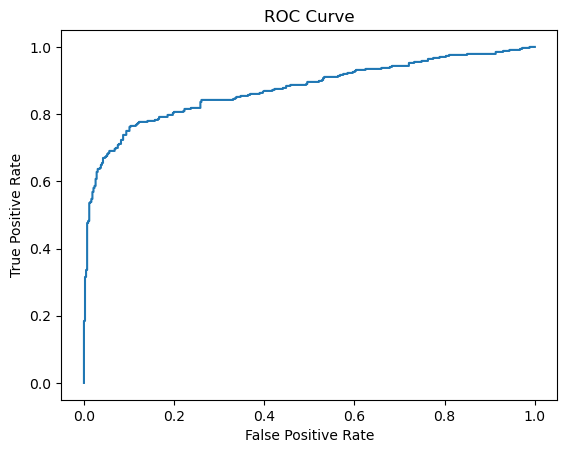

AUC value: 0.8742489660183321


In [290]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score


# Generate some data
y_true = y_test
y_score = roc_test.apply(get_prediction)

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_value = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# Print the AUC value
print("AUC value:", auc_value)

# I have played a little here with different probabity values

In [293]:
def get_target(outputs):
    sentiment = [1 if output>=0.48 else 0 for output in outputs]
    return pd.Series(sentiment)

y_pred = get_target(y_score)
y_pred.index = y_test.index
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy = {accuracy}")

Accuracy = 0.8333333333333334


In [256]:
def plot_confusion_matrix(confusion_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

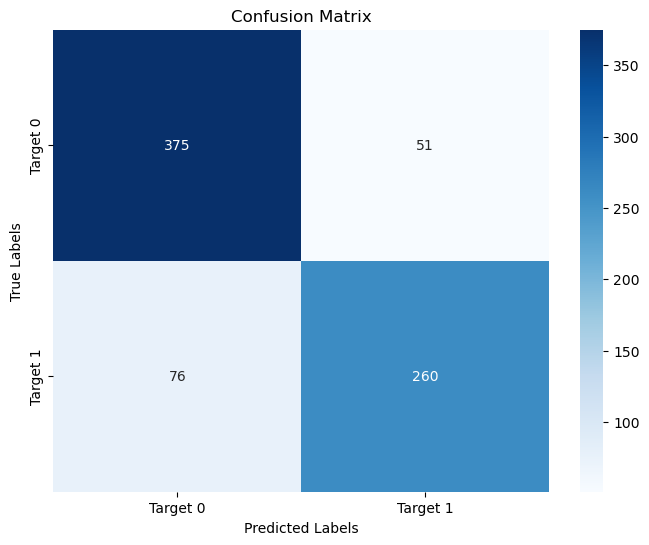

In [257]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(y_test, y_pred)
class_labels = ['Target 0', 'Target 1']
plot_confusion_matrix(confusion_mat, class_labels)

# We have total 127 incorrect predictions.

# Lets understand where model went wrong on test data

# First understand tweets which were disastrous, but model predicted them as non-disastrous

In [258]:
temp = X_test[(y_pred==0) & (y_test==1)]
for index in temp.index[:10]:
    #print(f"Original Text : {u_train[index]}")
    print(f"Cleaned Text : {temp[index]}")
    print("="*150)
# True Lable : {get_tag(y_test[index])} Predicted Lable: {get_tag(y_pred[index])}

Cleaned Text : so you have a new weapon that can cause unimaginable destruction
Cleaned Text : my favorite lady came to our volunteer meeting hopefully joining her youth collision and i am excite
Cleaned Text : ux fail of emv people want to insert and remove quickly like a gas pump stripe reader 1 person told me it crashed the pos
Cleaned Text : pandemonium in aba as woman delivers baby without face photos
Cleaned Text : its a miracle that mankind survived 70 years since one of the worst days in its history all bets are off if it will survive the next 70
Cleaned Text : wait i thought fecal hurricane was on scifi maybe that was turdnado ive been forgeting up a shit storm lately
Cleaned Text : todayûªs storm will pass let tomorrowûªs light greet you with a kiss bask in this loving warmth let your soul return to bliss
Cleaned Text : method in contemplation of incident an leading bridal landslide wiwnpfxa
Cleaned Text : 950 if a landslide tumbles down todayim on your side and if a twister 

# Now understand tweets which were non disastrous, but model predicted them as disastrous

In [259]:
temp = X_test[(y_pred==1) & (y_test==0)]
for i in range(10):
    print(f"Cleaned Text : {temp.iloc[i]}")
    print("="*150)

Cleaned Text : in response to trauma children of addicts develop a defensive self one that decreases vulnerability 3
Cleaned Text : who is bringing the tornadoes and floods who is bringing the climate change god is after america he is plaguing her farrakhan quote
Cleaned Text : shes a suicide bomb
Cleaned Text : the tubestrike is because tfl workers may have trouble planning downtime i hope none need emergency services
Cleaned Text : fairfax investigating firefighter over facebook post saying police should be put in ûbody bagsûª the washington post
Cleaned Text : sitting still in the cityofmemphis traffic is like sitting in a war zone they dont move for the police they dont care
Cleaned Text : armageddon averted by el patron ultimalucha
Cleaned Text : the secrets of the storm vortex the lightning catcher book û_
Cleaned Text : new crime knowing your rights punishable by death
Cleaned Text : bayelsa poll tension in bayelsa as patience jonathan plans to hijack apc pdp plans by former fir

# Finally, predict test data

In [276]:
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
test['text'] = test['text'].apply(clean_tweet)
y_score = test['text'].apply(get_prediction)

def get_target(outputs):
    sentiment = [1 if output>=0.54 else 0 for output in outputs]
    return sentiment

test_pred = get_target(y_score)



def get_tag(label):
    if label == 1:
        return 'Disaster'
    else:
        return 'NoT a Disaster'
    
for ind in range(20):
    print(f"Text: {test['text'][ind]}, prediction : {get_tag(test_pred[ind])}")
    print('-------------------')

Text: just happened a terrible car crash, prediction : Disaster
-------------------
Text: heard about earthquake is different cities stay safe everyone, prediction : Disaster
-------------------
Text: there is a forest fire at spot pond geese are fleeing across the street i cannot save them all, prediction : Disaster
-------------------
Text: apocalypse lighting spokane wildfires, prediction : Disaster
-------------------
Text: typhoon soudelor kills 28 in china and taiwan, prediction : Disaster
-------------------
Text: were shakingits an earthquake, prediction : Disaster
-------------------
Text: theyd probably still show more life than arsenal did yesterday eh eh, prediction : NoT a Disaster
-------------------
Text: hey how are you, prediction : NoT a Disaster
-------------------
Text: what a nice hat, prediction : NoT a Disaster
-------------------
Text: fuck off, prediction : NoT a Disaster
-------------------
Text: no i dont like cold, prediction : NoT a Disaster
---------------

In [277]:
sample_submission = pd.DataFrame()
sample_submission['id']=test['id']
sample_submission['target']=y_pred
sample_submission.to_csv("submission.csv", index=False)

# Now lets try to improve the performence

# Data Augmentation might help us in improving the result. So now i will predict the train data using above trained model and then auggment the train data for which model went wrong

# Predict train data

In [302]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score

y_train_score = X_train.apply(get_prediction)

y_train_pred = get_target(y_train_score)
y_train_pred.index = y_train.index

In [307]:
y_train_pred.to_csv('train_pred.csv')
X_train.to_csv('X_train.csv')
y_train.to_csv('y_train.csv')

# Select incorrect records

# train tweets which are predicted as disaster, but they were not disaster

In [312]:
temp1 = X_train[(y_train_pred==0) & (y_train==1)]
print(len(temp1))
for index in temp1.index[:10]:
    #print(f"Original Text : {u_train[index]}")
    print(f"Cleaned Text : {temp1[index]}")
    print("="*150)

558
Cleaned Text : please support this please cosponsor s 928 and support aid for sick and injured 911 responders renew911health
Cleaned Text : when you go to a concert and someone screams in your ear does it look like i wanna loose my hearing anytime soon
Cleaned Text : interesting approach but doesnt replace eyewitness video the ferguson case video
Cleaned Text : i will adamantly opposed to nuclear weapons
Cleaned Text : hello calgary important news please be advised
Cleaned Text : fotoset elanorofrohan 10th december 2013 green carpet in zurich for the swiss premiere of the desolation
Cleaned Text : and she wrapped his coat around herself it practically engulfed her
Cleaned Text : the dress memes have officially exploded on the internet
Cleaned Text : near them on the sand half sunk a shattered visage lies
Cleaned Text : seems they declared war against government


# train tweets which are predicted as non-disaster, but they were disaster

In [313]:
temp2 = X_train[(y_train_pred==1) & (y_train==0)]
print(len(temp2))
for index in temp2.index[:10]:
    #print(f"Original Text : {u_train[index]}")
    print(f"Cleaned Text : {temp2[index]}")
    print("="*150)

389
Cleaned Text : wackoes like michelebachman predict the world will soon be obliterated by a burning firey inferno but cant accept globalwarming hello
Cleaned Text : people like you should be charged after the inevitable rioting for contributing to it with your lies
Cleaned Text : ccot tcot radiation nuclear emergency tracking center
Cleaned Text : mom we didnt get home as fast as we wished me why is that mom there was an accident and some truck spilt mayonnaise all over
Cleaned Text : angry woman openly accuses nema of stealing relief materials meant for idps an angry internally displaced wom
Cleaned Text : its lights out again with stagetwo load shedding stagetwo load shedding will be in force between 5pm and 10pm
Cleaned Text : san bernardino i10 w eo redlands blvd trfc collisionno inj
Cleaned Text : theres a fire truck in this parking lot
Cleaned Text : cap the drive act represents the failure of senate republicans to address the structural shortfalls plaguing the highway trust f

In [314]:
incorrect_X_train = X_train[(y_train_pred != y_train)]
print(len(incorrect_X_train))

947


# For augmentation, i am going to replace noun,verb, adverb and adjective for incorrect records with other similar type of words. 

# So what i am doing is  i am selecting words and then cecking its pos tag. if it is a verb, adverb, noun or adjective, then i am using bert for calculating other similar type of words with the help of masked language modelling approach. Eventually, I am selecting the most similar word, which has same pos tag, and whose sentiemnt is similar to the sentiment of the original word. Note that this will take very long time to finish.

# Below is a helper function calculating sentiment

In [5]:
from transformers import pipeline
model = 'Seethal/sentiment_analysis_generic_dataset'
sentiment_classifier = pipeline("sentiment-analysis", model= model)

def sentiment(text):
    results = sentiment_classifier(text)  
    #print(results)
    if results[0]["label"] == 'LABEL_0':
        return 'neg'
    if results[0]["label"] == 'LABEL_2':
        return 'pos'
    else:
        return 'neu'

# Below is function for getting similar words using masked language modelling

In [6]:
from transformers import pipeline

def get_synonyms_bert(word, pos, top_n=5):
    fill_mask = pipeline(task="fill-mask", model="bert-base-uncased")
    masked_text = f"the most similar of {word} is {fill_mask.tokenizer.mask_token}."
    results = fill_mask(masked_text)
    synonyms = {result['token_str']:result['score'] for result in results[:top_n] 
                if 
                result['token_str'] != word 
                and  sentiment(word) == sentiment(result['token_str'])
                and pos == nlp(result['token_str'])[0].pos_}
    if synonyms:
        return sorted(synonyms.items(), key=lambda x:x[1])[-1][0]
    else:
        return word

# Below function check for POS and then replace the appropriate word with most similar word

In [9]:
# !python -m spacy download en_core_web_md

import spacy
nlp = spacy.load("en_core_web_md")
def is_noun_verb_adj(tag):
    allowed_tags = ['NOUN','ADJ', 'ADV', 'VERB']
    return tag in allowed_tags

def replace_with_synonyms(text):
    doc = nlp(text)
    replaced_text = []
    for token in doc:
        if is_noun_verb_adj(token.pos_):  
            synonym = get_synonyms_bert(token.text,token.pos_, top_n=50)
            replaced_text.append(synonym)
        else:
            replaced_text.append(token.text)

    return " ".join(replaced_text)


# Below is an example of what result you will get

In [11]:
text = "in response to trauma children of addicts develop a defensive self one that decreases vulnerability 3"
modified_text = replace_with_synonyms(text)

print("Original Text: ", text)
print("Modified Text: ", modified_text)

Original Text:  in response to trauma children of addicts develop a defensive self one that decreases vulnerability 3
Modified Text:  in rejection to death twins of addicts develop a defensive soul one that decreases failure 3


# below line will apply same sort of modification in each incorrectly predcited train records

In [ ]:
modified_X_train = incorrect_X_train.apply(replace_with_synonyms)

# 2nd Approach

# Combine Roberta with class based TF-IDF approach. Note: This is not exactly cTF-IDF, but a similar type of approach)

# I have calculated frequency of each word by class and then devided them with their frequency across the corpus. Doing this will give the weight to each word depending upon the class they belong the most

In [269]:
def class_based_weight(data, target):
    
    # Calculate frequency of each word accros the corpus
    count_vectorizer = CountVectorizer(stop_words = 'english')
    count_matrix = count_vectorizer.fit_transform(data)
    vocabulary = count_vectorizer.get_feature_names_out()
    vector_matrix = pd.DataFrame(count_matrix.toarray(), columns=vocabulary)
    word_frequency = vector_matrix.sum(axis=0)

    #############################################################
    # Calculate frequency of each word in disaster related documents
    positive_count_vectorizer = CountVectorizer(stop_words = 'english')
    positive_count_matrix = positive_count_vectorizer.fit_transform(data[target==1].values)
    positive_vocabulary = positive_count_vectorizer.get_feature_names_out()
    positive_vector_matrix = pd.DataFrame(positive_count_matrix.toarray(), columns=positive_vocabulary)
    missing_words = list(set(vocabulary) - set(positive_vocabulary))
    positive_vector_matrix[missing_words] = 0
    positive_word_frequency = positive_vector_matrix.sum(axis=0)

    ############################################################
     # Calculate frequency of each word in non-disaster related documents
    negative_count_vectorizer = CountVectorizer(stop_words = 'english')
    negative_count_matrix = negative_count_vectorizer.fit_transform(data[target==0].values)
    negative_vocabulary = negative_count_vectorizer.get_feature_names_out()
    negative_vector_matrix = pd.DataFrame(negative_count_matrix.toarray(), columns=negative_vocabulary)
    missing_words = list(set(vocabulary) - set(negative_vocabulary))
    negative_vector_matrix[missing_words] = 0
    negative_word_frequency = negative_vector_matrix.sum(axis=0)
    
    return word_frequency, positive_word_frequency, negative_word_frequency

vector_X_train = pd.Series(X_train).apply(clean_tweet, args=[True, True])
vector_X_test = pd.Series(X_test).apply(clean_tweet, args=[True, True])
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)
word_frequency, positive_word_frequency, negative_word_frequency = class_based_weight(vector_X_train, y_train)

In [270]:
def get_class_weight(text):
    wrods = text.split()
    neg = 1
    pos = 1
    total = 1
    for word in wrods:
        if word in word_frequency.index:
            total = total * word_frequency[word]
            if negative_word_frequency[word] != 0:
                neg = neg * negative_word_frequency[word]
            if positive_word_frequency[word] !=0:
                pos = pos + positive_word_frequency[word]
    pos = pos / total
    neg = neg / total
    return pos, neg


train_vectorizer_data = vector_X_train.apply(get_class_weight)
test_vectorizer_data = vector_X_test.apply(get_class_weight)

In [271]:
train = pd.DataFrame(list(train_vectorizer_data))
test = pd.DataFrame(list(test_vectorizer_data))

In [272]:
from catboost import CatBoostClassifier
catboost_model = CatBoostClassifier()
catboost_model.fit(train, y_train, silent=True)

from sklearn.metrics import accuracy_score
cat_pred = catboost_model.predict(test)
accuracy = accuracy_score(y_test, cat_pred)
print(f"Accuracy = {accuracy}")

Accuracy = 0.7729658792650919


In [273]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(train, y_train)

from sklearn.metrics import accuracy_score
xg_pred = xgb_model.predict(test)
accuracy = accuracy_score(y_test, xg_pred)
print(f"Accuracy = {accuracy}")

Accuracy = 0.7664041994750657


In [274]:
from sklearn.neighbors import KNeighborsClassifier
KNN_tf_idf_model = KNeighborsClassifier(n_neighbors=11)
KNN_tf_idf_model.fit(train, y_train)
knn_tf_idf_pred = KNN_tf_idf_model.predict(test)
accuracy = accuracy_score(y_test, knn_tf_idf_pred)
print(f"Accuracy = {accuracy}")

Accuracy = 0.7690288713910761


# KNN +  XG Boost + CAT Boost

In [275]:
from statistics import mode
ens_pred = np.array([knn_tf_idf_pred,xg_pred,cat_pred]).T
ens_pred = list(map(mode, ens_pred))
accuracy = accuracy_score(y_test, ens_pred)
print(f"Accuracy = {accuracy}")

Accuracy = 0.7755905511811023


# Combine Roberta with cTF-IDF as we did with above models KNN + XG Boost + CatBoost

# y_pred contains roberta results

In [295]:
from statistics import mode
ens_pred = np.array([ens_pred,y_pred]).T
ens_pred = list(map(mode, ens_pred))
accuracy = accuracy_score(y_test, ens_pred)
print(f"Accuracy = {accuracy}")

Accuracy = 0.7952755905511811
